# Network Analysis of ERP Components

Analyze the network of ERP papers - based on connections of papers that discuss multiple ERPs.

This network analysis is based on inferring connections based on articles that discuss multiple components (based on matching article IDs). 

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

from lisc.utils import SCDB, load_object

In [2]:
# Import custom project code
import sys
sys.path.append('../code')
from plts import plot_network

## Setup

In [3]:
# Settings
SAVE_FIG = True
SAVE_EXT = '.pdf'

In [4]:
# Set the name of the file to load
name = 'erps' # 'erps', 'test'

# Set the minimum number of papers for including a component
n_min = 150

In [5]:
# Set the file locations
db = SCDB('../data/')
figs_dir = '../data/figures/network/'

In [6]:
# Load data
words = load_object('words_' + name, directory=db, reload_results=True)

In [7]:
# Drop components without enough articles
words.drop_data(n_min)

## Set up Network

In [8]:
# Calculate the connections between components, based on overlapping articles
overlaps = np.zeros(shape=(words.n_terms, words.n_terms))
for ii, ei in enumerate(words.labels):
    for jj, ej in enumerate(words.labels):
        if ii == jj: continue
        overlaps[ii, jj] = len(set(words[ei].ids) & set(words[ej].ids))

In [9]:
# Initialize network graph, and add the nodes
network = nx.Graph()
for ind, erp in enumerate(words.labels):
    network.add_node(ind)

In [10]:
# Add weighted edges between nodes
for ii in range(words.n_terms):
    for jj in range(words.n_terms):
        if overlaps[ii, jj] > 0:
            network.add_edge(ii, jj, weight=overlaps[ii, jj])

In [11]:
# Collect the labels for each node
labels = {ind : label for ind, label in enumerate(words.labels)}

In [12]:
# Drop disconnected ERPs: components without connections to the network are dropped
drop_erps = ['VsEP']
drop_inds = [words.get_index(erp) for erp in drop_erps]
for ind in drop_inds:
    network.remove_node(ind)
    labels.pop(ind)

### Plot the ERP network

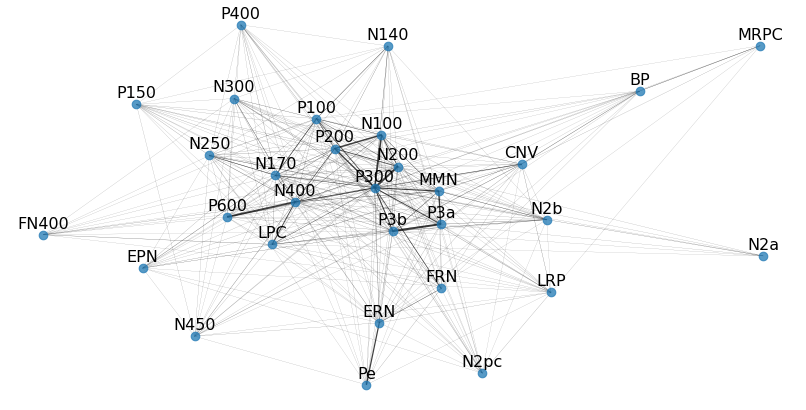

In [62]:
# Plot the network
plot_network(network, labels, layout_seed=29, figsize=(11, 5.5),
             save_fig=SAVE_FIG, file_name='erp_network.pdf',
             directory=figs_dir, save_kwargs={'transparent' : True})

## Measures

Evaluate some descriptive measures of the ERP network.

### Network Center

Calculate eccentricity and radius of the network:
- the eccentricity of a node is the maximum distance from the node to all other nodes. 
- the radius is the minimum eccentricity

Find the 'center' of the network - the node(s) with eccentricity equal to radius.

In [14]:
# Check network eccentricity and radius
print('Average eccentricity: \t {:2.2f}'.format(np.mean(list(nx.eccentricity(network).values()))))
print('Network radius: \t', nx.radius(network))

Average eccentricity: 	 1.97
Network radius: 	 1


In [15]:
# Check center(s)
centers = nx.center(network)
print('Network center(s): ', ', '.join([labels[ind] for ind in centers]))

Network center(s):  P300


### Descriptive Statistics

Check some descriptive measures of the network.

In [16]:
# Check some descriptive statistics of the network
print('Average clustering: \t\t{:1.2f}'.format(nx.average_clustering(network)))
print('Average node connectivity: \t{:1.2f}'.format(nx.average_node_connectivity(network)))
print('Average shortest path length: \t{:1.2f}'.format(nx.average_shortest_path_length(network)))

Average clustering: 		0.84
Average node connectivity: 	17.00
Average shortest path length: 	1.29


### Network Degree

The degree is the number of connections each node has to other nodes. 

In [17]:
# Check average degree
degrees = [val for key, val in network.degree]
print('Average degree: \t\t{:1.2f}'.format(np.mean(degrees)))

Average degree: 		20.60


### Edge Weights

Check details and descriptions of the edge weights.

In [18]:
# Check the strongest weight between two nodes
topa = max(dict(network.edges).items(), key=lambda x: x[1]['weight'])
print('Top association: ', labels[topa[0][0]], ' & ', labels[topa[0][1]], ':', topa[1]['weight'])

Top association:  P3a  &  P3b : 433.0


In [19]:
# Collect the set of weights per node
node_weights = []
for node_ind in network.nodes:
    node_edges = [edge for edge in network.edges() if node_ind in edge]
    node_weights.append([network[ne[0]][ne[1]]['weight'] for ne in node_edges])

In [20]:
# Collect the strongest link per node 
max_weight = []
for ind in labels.keys():
    max_ind = max(dict(network[ind]).items(), key=lambda x: x[1]['weight'])[0]
    max_weight.append(labels[max_ind])

### Measures per node

Check measures of interest for each node.

In [21]:
# Check measures per node
print("LABEL\t\tDEGREE\t\tAVG_WEIGHT (MIN-MAX)\t\tTOP-WEIGHT")
for label, degree, weights, top in zip(labels.values(), degrees, node_weights, max_weight):
    print('{:5s}\t\t{:2d}\t\t{:5.2f}\t   ({:1.0f} - {:3.0f})\t\t{:5s}'.format(\
        label, degree, np.median(weights), min(weights), max(weights), top))

LABEL		DEGREE		AVG_WEIGHT (MIN-MAX)		TOP-WEIGHT
P100 		27		 7.00	   (1 - 143)		N170 
P150 		17		 5.00	   (1 -  17)		N250 
P200 		26		16.00	   (1 - 314)		N100 
P300 		29		44.00	   (1 - 411)		N200 
P3a  		27		 8.00	   (1 - 433)		P3b  
P3b  		28		13.00	   (1 - 433)		P3a  
P400 		17		 4.00	   (1 -  21)		N170 
P600 		21		 5.00	   (1 - 389)		N400 
N100 		24		 9.50	   (1 - 348)		P300 
N140 		16		 3.00	   (1 -  72)		P100 
N170 		27		12.00	   (1 - 143)		P100 
N200 		27		10.00	   (2 - 411)		P300 
N2a  		 7		 4.00	   (1 -  22)		N2b  
N2b  		20		 4.00	   (1 -  68)		MMN  
N2pc 		19		 2.00	   (1 -  11)		P300 
N250 		23		 5.00	   (1 -  95)		N170 
N300 		21		 3.00	   (1 -  59)		N400 
N400 		25		16.00	   (3 - 389)		P600 
N450 		19		 3.00	   (1 -  11)		N400 
MMN  		26		 7.00	   (1 - 288)		P3a  
LPC  		26		 9.00	   (1 - 171)		N400 
CNV  		21		 8.00	   (1 -  90)		P300 
LRP  		20		 2.50	   (1 -  27)		P300 
BP   		15		 3.00	   (1 -  57)		MRPC 
ERN  		25		 7.00	   (1 - 257)		Pe   
Pe   		15		 2.00	   (1 - 25